<a href="https://colab.research.google.com/github/helveticacode/TSP/blob/main/%E9%83%BD%E5%B8%82%E8%A8%88%E7%94%BB%E3%81%B8%E3%81%AE%E3%82%A2%E3%83%97%E3%83%AD%E3%83%BC%E3%83%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#モジュールのimport
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
!pip install simanneal
from simanneal import Annealer
import numpy as np
from scipy.spatial import distance
import random
from google.colab import drive
drive.mount('/content/drive')
from decimal import *
import inspect
import math
import openpyxl
!pip install xlrd
import time
#inspect.getsource(Annealer)
#inspect.getsource(distance)

Mounted at /content/drive


In [ ]:

def att_distance(a,b): #aとbの間のatt距離を返す　a = [x_a,y_a] b = [x_b,y_b]
  xd = a[0] - b[0];
  yd = a[1] - b[1];
  def nint(a):
    b = int(a+0.5)
    return b
  rij = math.sqrt( (xd*xd + yd*yd) / 10.0 );
  tij = nint(rij)
  if tij<rij :
    dij = tij + 1;
  else:
    dij = tij;

  return dij


In [ ]:
def tsp_solve(towns_filename,distance_mesure,ideal_route,move_method = "2-opt",initial_method= "greedy",grid = "off",copy_method = "deepcopy"):


      # town -> 0 Long->1 Lati ->2
  towns_data = pd.read_csv('/content/drive/My Drive/colab/'+towns_filename+'.tsp', header=5,dtype={'Longitude': float, 'Latitude': float})
  df = towns_data['NODE_COORD_SECTION'].str.split(' ', expand=True)

  towns_data = df.rename(columns={0: 'Town',1: 'Longitude',2: 'Latitude'})
  gyo = len(towns_data)


  towns_data = towns_data.astype({'Latitude': float,"Longitude":float})

  for i in range(gyo):
    #print(towns_data['Longitude'][i])
    if math.isnan(towns_data['Longitude'][i]) is True:
          towns_data = towns_data.drop(i)
    elif math.isnan(towns_data['Latitude'][i]) is True:
          towns_data = towns_data.drop(i)

  if grid == "on":

    plt.figure(figsize=(10, 10))
    plt.scatter(towns_data['Longitude'], towns_data['Latitude'])
    for city, x, y in zip(towns_data['Town'], towns_data['Latitude'], towns_data['Longitude']):
        plt.text(y,x, city, alpha=0.5, size=12)
    plt.grid()


  class TravellingSalesmanProblem(Annealer):

      """Test annealer with a travelling salesman problem.
      """

      # pass extra data (the distance matrix) into the constructor
      def __init__(self, state, distance_matrix):
          self.distance_matrix = distance_matrix
          super(TravellingSalesmanProblem, self).__init__(state)  # important! 親クラスの__initが使える
      towns_data_method = towns_data
      def move(self):

          if move_method == "2-opt":
            """2-opt"""
            # no efficiency gain, just proof of concept
            # demonstrates returning the delta energy (optional)
            initial_energy = self.energy()

            a = random.randint(0, len(self.state) - 1)
            b = random.randint(0, len(self.state) - 1)
            if a >= b:
              bsave = b
              b = a
              a = bsave
            #これでa<=bになった
            while a<b:
              self.state[a], self.state[b] = self.state[b], self.state[a]
              a = a+1
              b = b-1

            return self.energy() - initial_energy

          elif move_method == "random":
            initial_energy = self.energy()
            a = random.randint(0, len(self.state) - 1)
            b = random.randint(0, len(self.state) - 1)
            self.state[a], self.state[b] = self.state[b], self.state[a]

            return self.energy() - initial_energy

      def energy(self):
          """Calculates the length of the route."""
          e = 0
          for i in range(len(self.state)):
              e += self.distance_matrix[self.state[i-1]][self.state[i]]

          return e
      energies = []
      def anneal(self):
          """Minimizes the energy of a system by simulated annealing.

          Parameters
          state : an initial arrangement of the system　初期値

          Returns
          (state, energy): the best state and energy found.　良さそうな位置とそのときのスコアを返す
          """
          step = 0
          self.start = time.time()

          # Precompute factor for exponential cooling from Tmax to Tmin
          if self.Tmin <= 0.0:
              raise Exception('Exponential cooling requires a minimum "\
                  "temperature greater than zero.')
          Tfactor = -math.log(self.Tmax / self.Tmin)# -log(Tmax/Tmin)

          # Note initial state
          T = self.Tmax
          E = self.energy()
          prevState = self.copy_state(self.state)
          prevEnergy = E
          self.best_state = self.copy_state(self.state)
          self.best_energy = E
          trials, accepts, improves = 0, 0, 0
          if self.updates > 0:
              updateWavelength = self.steps / self.updates
              self.update(step, T, E, None, None)

          # Attempt moves to new states
          while step < self.steps and not self.user_exit:
              step += 1
              # !!!!!!!!!!change the tempreture
              T = self.Tmax * math.exp(Tfactor * step / self.steps)
              dE = self.move()
              if dE is None:
                  E = self.energy()
                  dE = E - prevEnergy
              else:
                  E += dE
              trials += 1
              if dE > 0.0 and math.exp(-dE / T) < random.random():
                  # Restore previous state
                  self.state = self.copy_state(prevState)
                  E = prevEnergy
              else:
                  # Accept new state and compare to best state
                  accepts += 1
                  if dE < 0.0:
                      improves += 1
                  prevState = self.copy_state(self.state)
                  prevEnergy = E
                  if E < self.best_energy:
                      self.best_state = self.copy_state(self.state)
                      self.best_energy = E
              if self.updates > 1:
                  if (step // updateWavelength) > ((step - 1) // updateWavelength):
                      self.update(
                          step, T, E, accepts / trials, improves / trials)
                      trials, accepts, improves = 0, 0, 0
              self.energies.append(E)

          self.state = self.copy_state(self.best_state)
          if self.save_state_on_exit:
              self.save_state()

          # Return best state and energy
          return self.best_state, self.best_energy


  mat = towns_data[['Latitude', 'Longitude']].values
  mat

  #dist_mat = distance.cdist(mat, mat, metric='euclidean') # ユークリッド距離

  distance_matrix = {}
  for i, town in enumerate(towns_data['Town']):
      if town not in distance_matrix.keys():
          distance_matrix[town] = {}
          a =[towns_data['Longitude'][i],towns_data['Latitude'][i]]
      for j, town2 in enumerate(towns_data['Town']):
          b =[towns_data['Longitude'][j],towns_data['Latitude'][j]]
          distance_matrix[town][town2] = distance_mesure(a,b)
  """
  init_state = list(_data['Town'])
  random.shuffle(init_state)
  """

  states = list(towns_data['Town'])
  init_state = []

  def initial_energy(state):
      """Calculates the length of the route."""
      e = 0
      for i in range(len(state)):
          e += distance_matrix[state[i-1]][state[i]]
      return e

  if initial_method == "greedy":

    len_states = len(states)
    start_townname = states[0]
    init_state.append(start_townname)

    town_keys = []
    now_key = 0   #スタート地点のkey
    calls = []
    for i in range(len_states):
      town_keys.append(i)

    town_keys.remove(now_key)
    calls.append(now_key)
    for _ in range(len_states-1):
      short_distance = 10000000000000000000000000
      """-------find min distance near city--------------"""
      for city in town_keys:
        if city not in calls:
          distance = distance_matrix[towns_data['Town'][now_key]][towns_data['Town'][city]]
          if distance < short_distance:
            short_distance = distance
            save_point = city
      """-----------------------"""
      now_key = save_point
      init_state.append(towns_data['Town'][save_point])
      town_keys.remove(save_point)
      calls.append(save_point)

  if initial_method == "random":
    random.shuffle(init_state)

  if grid == 'on':
    plt.figure(figsize=(10, 10))
    Xs = []
    Ys = []
    for i in range(len(init_state)):
        Xs.append(list(towns_data[towns_data['Town'] == init_state[i]].iloc[:, 2])[0])
        Ys.append(list(towns_data[towns_data['Town'] == init_state[i]].iloc[:, 1])[0])
    Xs.append(list(towns_data[towns_data['Town'] == init_state[0]].iloc[:, 2])[0])
    Ys.append(list(towns_data[towns_data['Town'] == init_state[0]].iloc[:, 1])[0])
    plt.plot(Ys, Xs)
    for city, x, y in zip(towns_data['Town'], towns_data['Latitude'], towns_data['Longitude']):
        plt.text(y,x, city, alpha=0.5, size=12)

  initial_e = initial_energy(init_state)
  #print("initial energy is "+str(initial_e))
  #distance_matrix



  tsp = TravellingSalesmanProblem(init_state, distance_matrix)
  tsp.set_schedule(tsp.auto(minutes=0.2))
  tsp.copy_strategy = "method"
  state, e = tsp.anneal()

  while state[0] != '1':
          state = state[1:] + state[:1]  # rotate NYC to start

  #print("%i mile route:" % e)
  route_map = " ➞  ".join(state)
  #mistake = e*100/ideal_route - 100
  #print("mistake is"+str(mistake))

  if grid == 'on':
    plt.figure(figsize=(10, 10))
    Xs = []
    Ys = []
    for i in range(len(state)):
        Xs.append(list(towns_data[towns_data['Town'] == state[i]].iloc[:, 2])[0])
        Ys.append(list(towns_data[towns_data['Town'] == state[i]].iloc[:, 1])[0])
    Xs.append(list(towns_data[towns_data['Town'] == state[0]].iloc[:, 2])[0])
    Ys.append(list(towns_data[towns_data['Town'] == state[0]].iloc[:, 1])[0])
    plt.plot(Ys, Xs)
    for city, x, y in zip(towns_data['Town'], towns_data['Latitude'], towns_data['Longitude']):
        plt.text(y, x, city, alpha=0.5, size=12)

  #print("energy of the anneal route is "+str(e)+", energy of the initial route is "+str(initial_e))

  initial_route = initial_e
  result = e
  return [towns_filename,ideal_route,distance_mesure.__name__,move_method,initial_method,initial_route,result,route_map,tsp.energies,tsp]

In [ ]:
results = tsp_solve(towns_filename = "att48",distance_mesure = att_distance,ideal_route=10628,move_method = "2-opt",initial_method= "greedy",grid = "off")

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 Temperature        Energy    Accept   Improve     Elapsed   Remaining


In [ ]:
energies = results[-1]
xlabel = []
for i in range(len(energies)):
  xlabel.append(i)

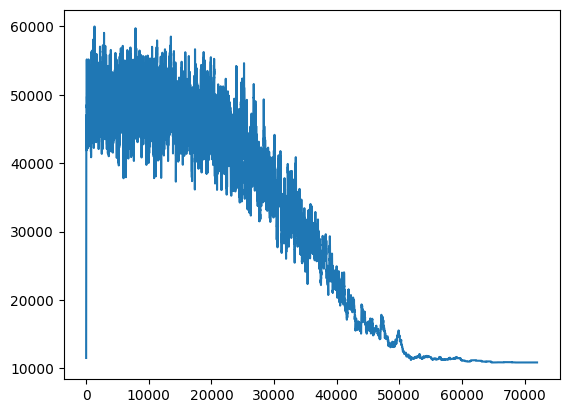

In [ ]:
plt.plot(xlabel,energies)

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 Temperature        Energy    Accept   Improve     Elapsed   Remaining


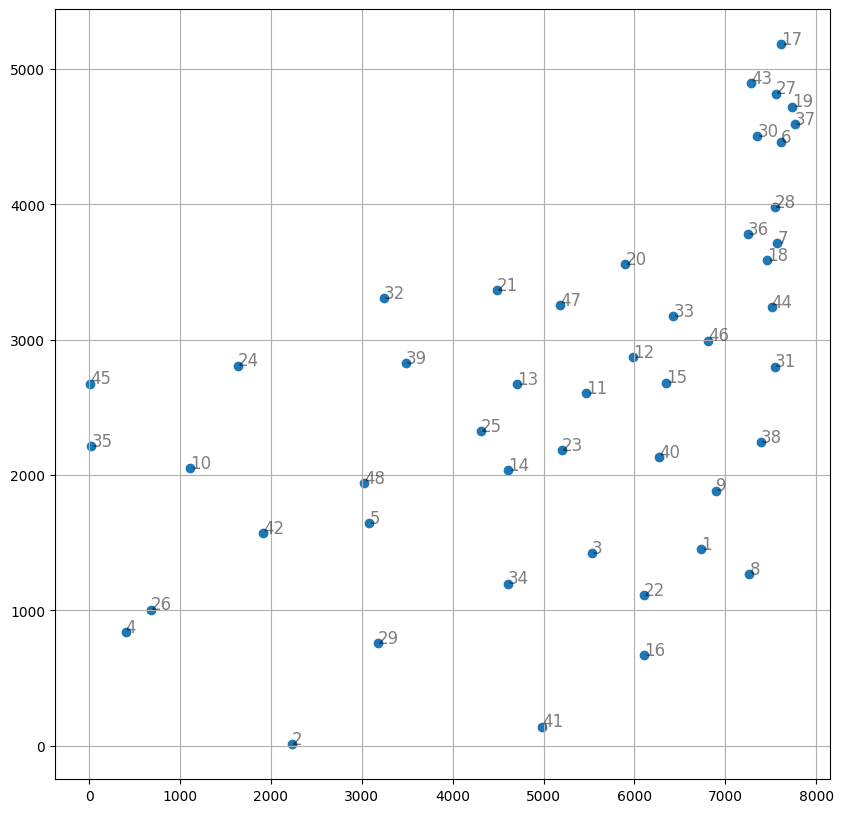

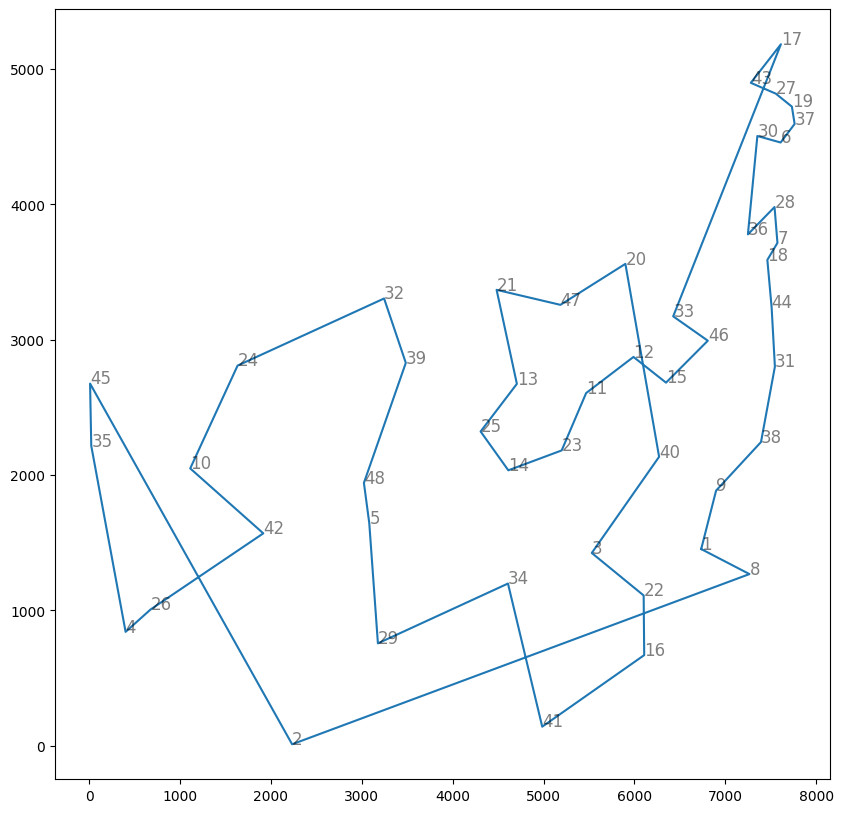

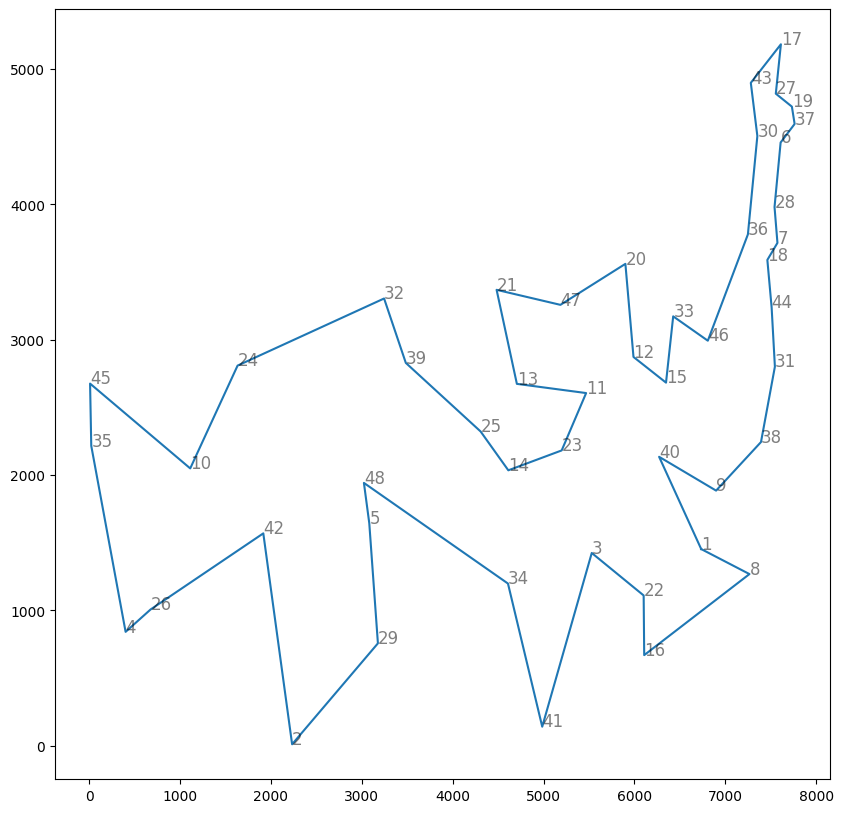

In [ ]:
results = tsp_solve(towns_filename = "att48",distance_mesure = att_distance,ideal_route=10628,move_method = "2-opt",initial_method= "greedy",grid = "on")

In [ ]:
tsp = results[-1]
new_distance = tsp.distance_matrix
#通行止めにしたい都市を入れる
new_distance["29"]["34"] = 100000000000000000000000
new_distance["34"]["29"] = 100000000000000000000000
new_distance["21"]["32"] = 100000000000000000000000
new_distance["32"]["21"] = 100000000000000000000000
print(new_distance)

{'1': {'1': 0, '2': 1495, '3': 381, '4': 2012, '5': 1157, '6': 990, '7': 764, '8': 178, '9': 147, '10': 1788, '11': 542, '12': 508, '13': 749, '14': 696, '15': 408, '16': 318, '17': 1213, '18': 714, '19': 1082, '20': 717, '21': 935, '22': 228, '23': 538, '24': 1670, '25': 816, '26': 1922, '27': 1096, '28': 840, '29': 1147, '30': 986, '31': 498, '32': 1250, '33': 553, '34': 678, '35': 2136, '36': 754, '37': 1046, '38': 326, '39': 1117, '40': 261, '41': 692, '42': 1525, '43': 1104, '44': 616, '45': 2162, '46': 488, '47': 753, '48': 1184}, '2': {'1': 1495, '2': 0, '3': 1135, '4': 637, '5': 583, '6': 2207, '7': 2056, '8': 1641, '9': 1590, '10': 736, '11': 1312, '12': 1494, '13': 1150, '14': 988, '15': 1552, '16': 1243, '17': 2360, '18': 2004, '19': 2291, '20': 1615, '21': 1279, '22': 1272, '23': 1163, '24': 906, '25': 983, '26': 585, '27': 2269, '28': 2097, '29': 381, '30': 2155, '31': 1898, '32': 1091, '33': 1661, '34': 840, '35': 988, '36': 1984, '37': 2272, '38': 1778, '39': 976, '40': 

In [ ]:
def new_tsp_solve(towns_filename,distance_mesure,ideal_route,move_method = "2-opt",initial_method= "greedy",grid = "off",copy_method = "deepcopy"):


      # town -> 0 Long->1 Lati ->2
  towns_data = pd.read_csv('/content/drive/My Drive/colab/'+towns_filename+'.tsp', header=5,dtype={'Longitude': float, 'Latitude': float})
  df = towns_data['NODE_COORD_SECTION'].str.split(' ', expand=True)

  towns_data = df.rename(columns={0: 'Town',1: 'Longitude',2: 'Latitude'})
  gyo = len(towns_data)


  towns_data = towns_data.astype({'Latitude': float,"Longitude":float})

  for i in range(gyo):
    #print(towns_data['Longitude'][i])
    if math.isnan(towns_data['Longitude'][i]) is True:
          towns_data = towns_data.drop(i)
    elif math.isnan(towns_data['Latitude'][i]) is True:
          towns_data = towns_data.drop(i)

  if grid == "on":

    plt.figure(figsize=(10, 10))
    plt.scatter(towns_data['Longitude'], towns_data['Latitude'])
    for city, x, y in zip(towns_data['Town'], towns_data['Latitude'], towns_data['Longitude']):
        plt.text(y,x, city, alpha=0.5, size=12)
    plt.grid()


  class TravellingSalesmanProblem(Annealer):

      """Test annealer with a travelling salesman problem.
      """

      # pass extra data (the distance matrix) into the constructor
      def __init__(self, state, distance_matrix):
          self.distance_matrix = distance_matrix
          super(TravellingSalesmanProblem, self).__init__(state)  # important! 親クラスの__initが使える
      towns_data_method = towns_data
      def move(self):

          if move_method == "2-opt":
            """2-opt"""
            # no efficiency gain, just proof of concept
            # demonstrates returning the delta energy (optional)
            initial_energy = self.energy()

            a = random.randint(0, len(self.state) - 1)
            b = random.randint(0, len(self.state) - 1)
            if a >= b:
              bsave = b
              b = a
              a = bsave
            #これでa<=bになった
            while a<b:
              self.state[a], self.state[b] = self.state[b], self.state[a]
              a = a+1
              b = b-1

            return self.energy() - initial_energy

          elif move_method == "random":
            initial_energy = self.energy()
            a = random.randint(0, len(self.state) - 1)
            b = random.randint(0, len(self.state) - 1)
            self.state[a], self.state[b] = self.state[b], self.state[a]

            return self.energy() - initial_energy

      def energy(self):
          """Calculates the length of the route."""
          e = 0
          for i in range(len(self.state)):
              e += self.distance_matrix[self.state[i-1]][self.state[i]]

          return e
      energies = []
      def anneal(self):
          """Minimizes the energy of a system by simulated annealing.

          Parameters
          state : an initial arrangement of the system　初期値

          Returns
          (state, energy): the best state and energy found.　良さそうな位置とそのときのスコアを返す
          """
          step = 0
          self.start = time.time()

          # Precompute factor for exponential cooling from Tmax to Tmin
          if self.Tmin <= 0.0:
              raise Exception('Exponential cooling requires a minimum "\
                  "temperature greater than zero.')
          Tfactor = -math.log(self.Tmax / self.Tmin)# -log(Tmax/Tmin)

          # Note initial state
          T = self.Tmax
          E = self.energy()
          prevState = self.copy_state(self.state)
          prevEnergy = E
          self.best_state = self.copy_state(self.state)
          self.best_energy = E
          trials, accepts, improves = 0, 0, 0
          if self.updates > 0:
              updateWavelength = self.steps / self.updates
              self.update(step, T, E, None, None)

          # Attempt moves to new states
          while step < self.steps and not self.user_exit:
              step += 1
              # !!!!!!!!!!change the tempreture
              T = self.Tmax * math.exp(Tfactor * step / self.steps)
              dE = self.move()
              if dE is None:
                  E = self.energy()
                  dE = E - prevEnergy
              else:
                  E += dE
              trials += 1
              if dE > 0.0 and math.exp(-dE / T) < random.random():
                  # Restore previous state
                  self.state = self.copy_state(prevState)
                  E = prevEnergy
              else:
                  # Accept new state and compare to best state
                  accepts += 1
                  if dE < 0.0:
                      improves += 1
                  prevState = self.copy_state(self.state)
                  prevEnergy = E
                  if E < self.best_energy:
                      self.best_state = self.copy_state(self.state)
                      self.best_energy = E
              if self.updates > 1:
                  if (step // updateWavelength) > ((step - 1) // updateWavelength):
                      self.update(
                          step, T, E, accepts / trials, improves / trials)
                      trials, accepts, improves = 0, 0, 0
              self.energies.append(E)

          self.state = self.copy_state(self.best_state)
          if self.save_state_on_exit:
              self.save_state()

          # Return best state and energy
          return self.best_state, self.best_energy


  mat = towns_data[['Latitude', 'Longitude']].values
  mat

  #dist_mat = distance.cdist(mat, mat, metric='euclidean') # ユークリッド距離

  distance_matrix = new_distance
  """
  init_state = list(_data['Town'])
  random.shuffle(init_state)
  """

  states = list(towns_data['Town'])
  init_state = []

  def initial_energy(state):
      """Calculates the length of the route."""
      e = 0
      for i in range(len(state)):
          e += distance_matrix[state[i-1]][state[i]]
      return e

  if initial_method == "greedy":

    len_states = len(states)
    start_townname = states[0]
    init_state.append(start_townname)

    town_keys = []
    now_key = 0   #スタート地点のkey
    calls = []
    for i in range(len_states):
      town_keys.append(i)

    town_keys.remove(now_key)
    calls.append(now_key)
    for _ in range(len_states-1):
      short_distance = 10000000000000000000000000
      """-------find min distance near city--------------"""
      for city in town_keys:
        if city not in calls:
          distance = distance_matrix[towns_data['Town'][now_key]][towns_data['Town'][city]]
          if distance < short_distance:
            short_distance = distance
            save_point = city
      """-----------------------"""
      now_key = save_point
      init_state.append(towns_data['Town'][save_point])
      town_keys.remove(save_point)
      calls.append(save_point)

  if initial_method == "random":
    random.shuffle(init_state)

  if grid == 'on':
    plt.figure(figsize=(10, 10))
    Xs = []
    Ys = []
    for i in range(len(init_state)):
        Xs.append(list(towns_data[towns_data['Town'] == init_state[i]].iloc[:, 2])[0])
        Ys.append(list(towns_data[towns_data['Town'] == init_state[i]].iloc[:, 1])[0])
    Xs.append(list(towns_data[towns_data['Town'] == init_state[0]].iloc[:, 2])[0])
    Ys.append(list(towns_data[towns_data['Town'] == init_state[0]].iloc[:, 1])[0])
    plt.plot(Ys, Xs)
    for city, x, y in zip(towns_data['Town'], towns_data['Latitude'], towns_data['Longitude']):
        plt.text(y,x, city, alpha=0.5, size=12)

  initial_e = initial_energy(init_state)
  #print("initial energy is "+str(initial_e))
  #distance_matrix



  tsp = TravellingSalesmanProblem(init_state, distance_matrix)
  tsp.set_schedule(tsp.auto(minutes=0.2))
  tsp.copy_strategy = "method"
  state, e = tsp.anneal()

  while state[0] != '1':
          state = state[1:] + state[:1]  # rotate NYC to start

  #print("%i mile route:" % e)
  route_map = " ➞  ".join(state)
  #mistake = e*100/ideal_route - 100
  #print("mistake is"+str(mistake))

  if grid == 'on':
    plt.figure(figsize=(10, 10))
    Xs = []
    Ys = []
    for i in range(len(state)):
        Xs.append(list(towns_data[towns_data['Town'] == state[i]].iloc[:, 2])[0])
        Ys.append(list(towns_data[towns_data['Town'] == state[i]].iloc[:, 1])[0])
    Xs.append(list(towns_data[towns_data['Town'] == state[0]].iloc[:, 2])[0])
    Ys.append(list(towns_data[towns_data['Town'] == state[0]].iloc[:, 1])[0])
    plt.plot(Ys, Xs)
    for city, x, y in zip(towns_data['Town'], towns_data['Latitude'], towns_data['Longitude']):
        plt.text(y, x, city, alpha=0.5, size=12)

  #print("energy of the anneal route is "+str(e)+", energy of the initial route is "+str(initial_e))

  initial_route = initial_e
  result = e
  return [towns_filename,ideal_route,distance_mesure.__name__,move_method,initial_method,initial_route,result,route_map,tsp.energies,tsp]

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 Temperature        Energy    Accept   Improve     Elapsed   Remaining


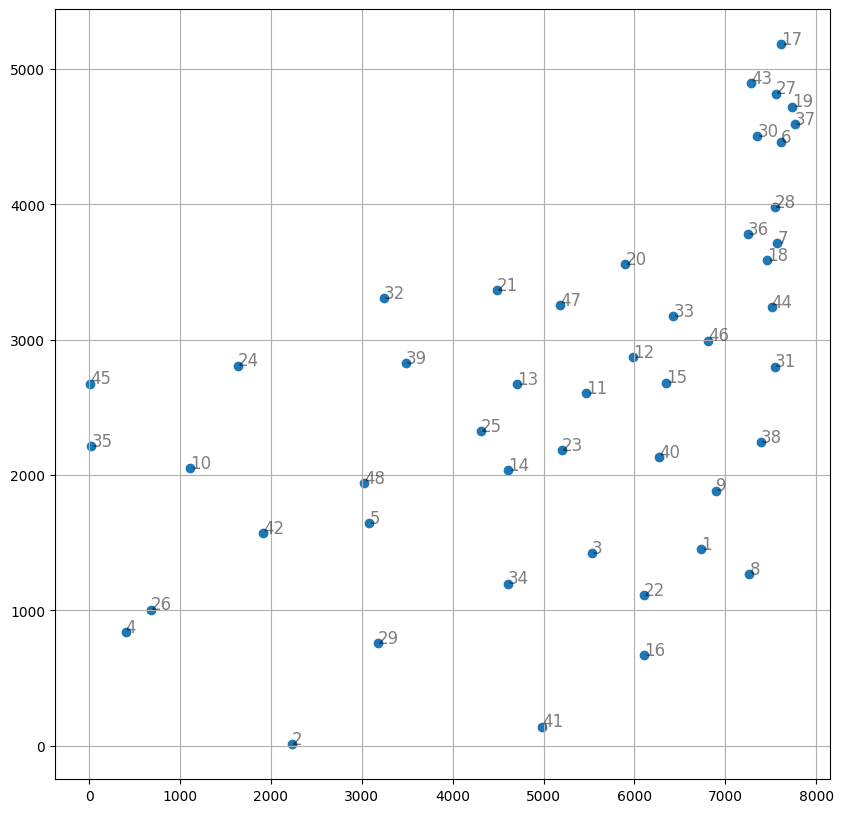

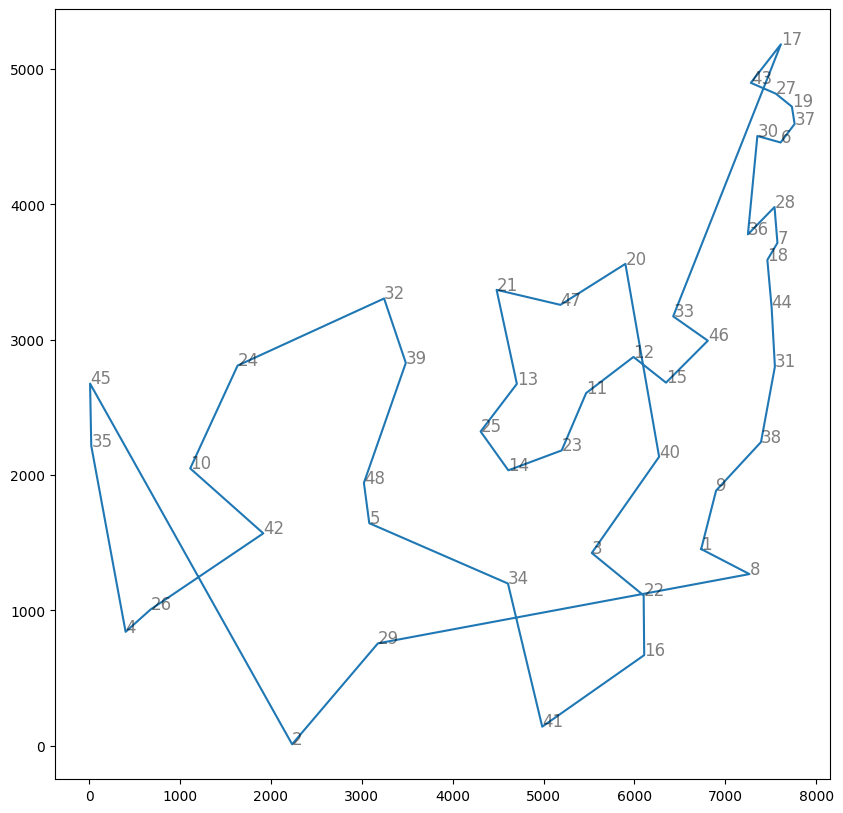

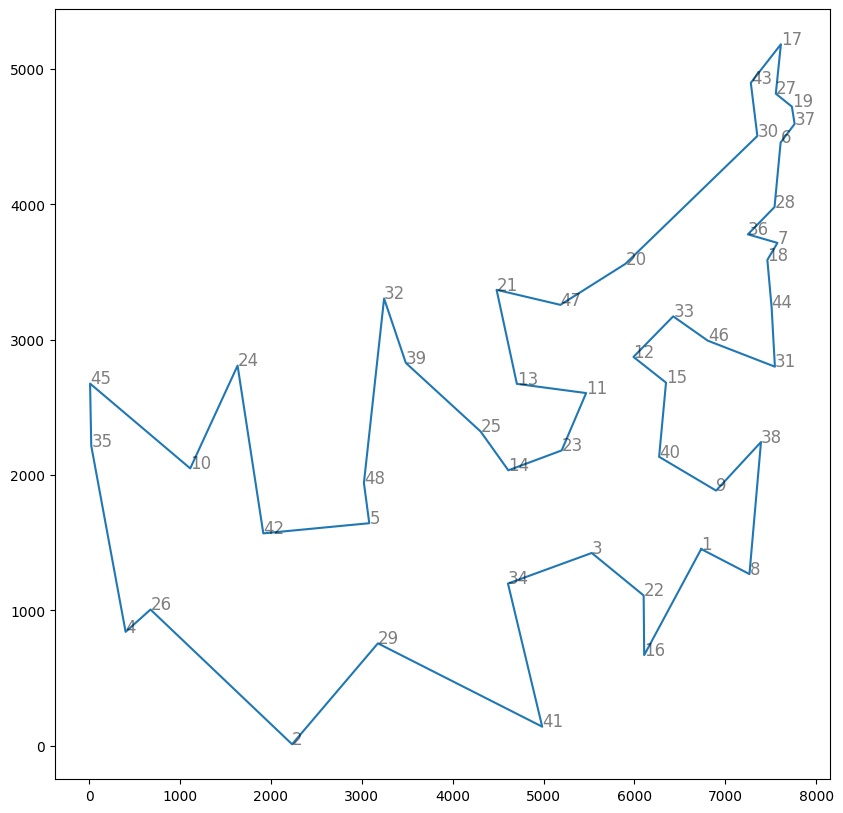

In [ ]:
new_results = new_tsp_solve(towns_filename = "att48",distance_mesure = att_distance,ideal_route=10628,move_method = "2-opt",initial_method= "greedy",grid = "on")

In [ ]:
print(tsp.towns_data_method)

   Town  Longitude  Latitude
0     1     6734.0    1453.0
1     2     2233.0      10.0
2     3     5530.0    1424.0
3     4      401.0     841.0
4     5     3082.0    1644.0
5     6     7608.0    4458.0
6     7     7573.0    3716.0
7     8     7265.0    1268.0
8     9     6898.0    1885.0
9    10     1112.0    2049.0
10   11     5468.0    2606.0
11   12     5989.0    2873.0
12   13     4706.0    2674.0
13   14     4612.0    2035.0
14   15     6347.0    2683.0
15   16     6107.0     669.0
16   17     7611.0    5184.0
17   18     7462.0    3590.0
18   19     7732.0    4723.0
19   20     5900.0    3561.0
20   21     4483.0    3369.0
21   22     6101.0    1110.0
22   23     5199.0    2182.0
23   24     1633.0    2809.0
24   25     4307.0    2322.0
25   26      675.0    1006.0
26   27     7555.0    4819.0
27   28     7541.0    3981.0
28   29     3177.0     756.0
29   30     7352.0    4506.0
30   31     7545.0    2801.0
31   32     3245.0    3305.0
32   33     6426.0    3173.0
33   34     46

In [ ]:
def new_tsp_solve(towns_filename,distance_mesure,ideal_route,move_method = "2-opt",initial_method= "greedy",grid = "off",copy_method = "deepcopy"):


      # town -> 0 Long->1 Lati ->2
  towns_data = pd.read_csv('/content/drive/My Drive/colab/'+towns_filename+'.tsp', header=5,dtype={'Longitude': float, 'Latitude': float})
  df = towns_data['NODE_COORD_SECTION'].str.split(' ', expand=True)

  towns_data = df.rename(columns={0: 'Town',1: 'Longitude',2: 'Latitude'})
  gyo = len(towns_data)


  towns_data = towns_data.astype({'Latitude': float,"Longitude":float})

  for i in range(gyo):
    #print(towns_data['Longitude'][i])
    if math.isnan(towns_data['Longitude'][i]) is True:
          towns_data = towns_data.drop(i)
    elif math.isnan(towns_data['Latitude'][i]) is True:
          towns_data = towns_data.drop(i)

  if grid == "on":

    plt.figure(figsize=(10, 10))
    plt.scatter(towns_data['Longitude'], towns_data['Latitude'])
    for city, x, y in zip(towns_data['Town'], towns_data['Latitude'], towns_data['Longitude']):
        plt.text(y,x, city, alpha=0.5, size=12)
    plt.grid()


  class TravellingSalesmanProblem(Annealer):

      """Test annealer with a travelling salesman problem.
      """
      towns_data_method = towns_data
      # pass extra data (the distance matrix) into the constructor
      def __init__(self, state, distance_matrix):
          self.distance_matrix = distance_matrix
          super(TravellingSalesmanProblem, self).__init__(state)  # important! 親クラスの__initが使える

      def move(self):

          if move_method == "2-opt":
            """2-opt"""
            # no efficiency gain, just proof of concept
            # demonstrates returning the delta energy (optional)
            initial_energy = self.energy()
            initial_stat = self.state
            special_edge = ["26","10"]
            # !! don't choice the edge which is decided
            a = random.randint(0, len(self.state) - 1)
            b = random.randint(0, len(self.state) - 1)
            if a >= b:
              bsave = b
              b = a
              a = bsave
            #これでa<=bになった

            while a<b:
              self.state[a], self.state[b] = self.state[b], self.state[a]
              a = a+1
              b = b-1
            index_26_next =self.state.index("26")+1
            if self.state[0] != "26":
              self.state = initial_stat
            if self.state[1] != "10":
              self.state = initial_stat

            return self.energy() - initial_energy

          elif move_method == "random":
            initial_energy = self.energy()
            a = random.randint(0, len(self.state) - 1)
            b = random.randint(0, len(self.state) - 1)
            self.state[a], self.state[b] = self.state[b], self.state[a]

            return self.energy() - initial_energy

      def energy(self):
          """Calculates the length of the route."""
          e = 0
          for i in range(len(self.state)):
              e += self.distance_matrix[self.state[i-1]][self.state[i]]

          return e
      energies = []
      def anneal(self):
          """Minimizes the energy of a system by simulated annealing.

          Parameters
          state : an initial arrangement of the system　初期値

          Returns
          (state, energy): the best state and energy found.　良さそうな位置とそのときのスコアを返す
          """
          step = 0
          self.start = time.time()

          # Precompute factor for exponential cooling from Tmax to Tmin
          if self.Tmin <= 0.0:
              raise Exception('Exponential cooling requires a minimum "\
                  "temperature greater than zero.')
          Tfactor = -math.log(self.Tmax / self.Tmin)# -log(Tmax/Tmin)

          # Note initial state
          T = self.Tmax
          E = self.energy()
          prevState = self.copy_state(self.state)
          prevEnergy = E
          self.best_state = self.copy_state(self.state)
          self.best_energy = E
          trials, accepts, improves = 0, 0, 0
          if self.updates > 0:
              updateWavelength = self.steps / self.updates
              self.update(step, T, E, None, None)

          # Attempt moves to new states
          while step < self.steps and not self.user_exit:
              step += 1
              # !!!!!!!!!!change the tempreture
              T = self.Tmax * math.exp(Tfactor * step / self.steps)
              dE = self.move()
              if dE is None:
                  E = self.energy()
                  dE = E - prevEnergy
              else:
                  E += dE
              trials += 1
              if dE > 0.0 and math.exp(-dE / T) < random.random():
                  # Restore previous state
                  self.state = self.copy_state(prevState)
                  E = prevEnergy
              else:
                  # Accept new state and compare to best state
                  accepts += 1
                  if dE < 0.0:
                      improves += 1
                  prevState = self.copy_state(self.state)
                  prevEnergy = E
                  if E < self.best_energy:
                      self.best_state = self.copy_state(self.state)
                      self.best_energy = E
              if self.updates > 1:
                  if (step // updateWavelength) > ((step - 1) // updateWavelength):
                      self.update(
                          step, T, E, accepts / trials, improves / trials)
                      trials, accepts, improves = 0, 0, 0
              self.energies.append(E)

          self.state = self.copy_state(self.best_state)
          if self.save_state_on_exit:
              self.save_state()

          # Return best state and energy
          return self.best_state, self.best_energy


  mat = towns_data[['Latitude', 'Longitude']].values
  mat

  #dist_mat = distance.cdist(mat, mat, metric='euclidean') # ユークリッド距離

  distance_matrix = new_distance
  """
  init_state = list(_data['Town'])
  random.shuffle(init_state)
  """

  states = list(towns_data['Town'])
  init_state = []

  def initial_energy(state):
      """Calculates the length of the route."""
      e = 0
      for i in range(len(state)):
          e += distance_matrix[state[i-1]][state[i]]
      return e

  if initial_method == "greedy":

    len_states = len(states)
    start_townname = states[0]


    town_keys = []
    now_key = 25   #スタート地点のkey
    special_key = 9
    calls = []
    for i in range(len_states):
      town_keys.append(i)

    town_keys.remove(now_key)
    town_keys.remove(special_key)
    calls.append(now_key)
    calls.append(special_key)
    init_state.append(towns_data['Town'][25])
    init_state.append(towns_data['Town'][9])
    for _ in range(len_states-2):
      short_distance = 10000000000000000000000000
      """-------find min distance near city--------------"""
      for city in town_keys:

        if city not in calls:
          distance = distance_matrix[towns_data['Town'][now_key]][towns_data['Town'][city]]
          if distance < short_distance:
            short_distance = distance
            save_point = city

      """-----------------------"""
      now_key = save_point
      init_state.append(towns_data['Town'][save_point])
      town_keys.remove(save_point)
      calls.append(save_point)

  if initial_method == "random":
    random.shuffle(init_state)

  if grid == 'on':
    plt.figure(figsize=(10, 10))
    Xs = []
    Ys = []
    for i in range(len(init_state)):
        Xs.append(list(towns_data[towns_data['Town'] == init_state[i]].iloc[:, 2])[0])
        Ys.append(list(towns_data[towns_data['Town'] == init_state[i]].iloc[:, 1])[0])
    Xs.append(list(towns_data[towns_data['Town'] == init_state[0]].iloc[:, 2])[0])
    Ys.append(list(towns_data[towns_data['Town'] == init_state[0]].iloc[:, 1])[0])
    plt.plot(Ys, Xs)
    for city, x, y in zip(towns_data['Town'], towns_data['Latitude'], towns_data['Longitude']):
        plt.text(y,x, city, alpha=0.5, size=12)

  initial_e = initial_energy(init_state)
  #print("initial energy is "+str(initial_e))
  #distance_matrix



  tsp = TravellingSalesmanProblem(init_state, distance_matrix)
  tsp.set_schedule(tsp.auto(minutes=0.2))
  tsp.copy_strategy = "method"
  state, e = tsp.anneal()

  while state[0] != '1':
          state = state[1:] + state[:1]  # rotate NYC to start

  #print("%i mile route:" % e)
  route_map = " ➞  ".join(state)
  #mistake = e*100/ideal_route - 100
  #print("mistake is"+str(mistake))

  if grid == 'on':
    plt.figure(figsize=(10, 10))
    Xs = []
    Ys = []
    for i in range(len(state)):
        Xs.append(list(towns_data[towns_data['Town'] == state[i]].iloc[:, 2])[0])
        Ys.append(list(towns_data[towns_data['Town'] == state[i]].iloc[:, 1])[0])
    Xs.append(list(towns_data[towns_data['Town'] == state[0]].iloc[:, 2])[0])
    Ys.append(list(towns_data[towns_data['Town'] == state[0]].iloc[:, 1])[0])
    plt.plot(Ys, Xs)
    for city, x, y in zip(towns_data['Town'], towns_data['Latitude'], towns_data['Longitude']):
        plt.text(y, x, city, alpha=0.5, size=12)

  #print("energy of the anneal route is "+str(e)+", energy of the initial route is "+str(initial_e))

  initial_route = initial_e
  result = e
  return [towns_filename,ideal_route,distance_mesure.__name__,move_method,initial_method,initial_route,result,route_map,tsp.energies,tsp]

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
 Temperature        Energy    Accept   Improve     Elapsed   Remaining


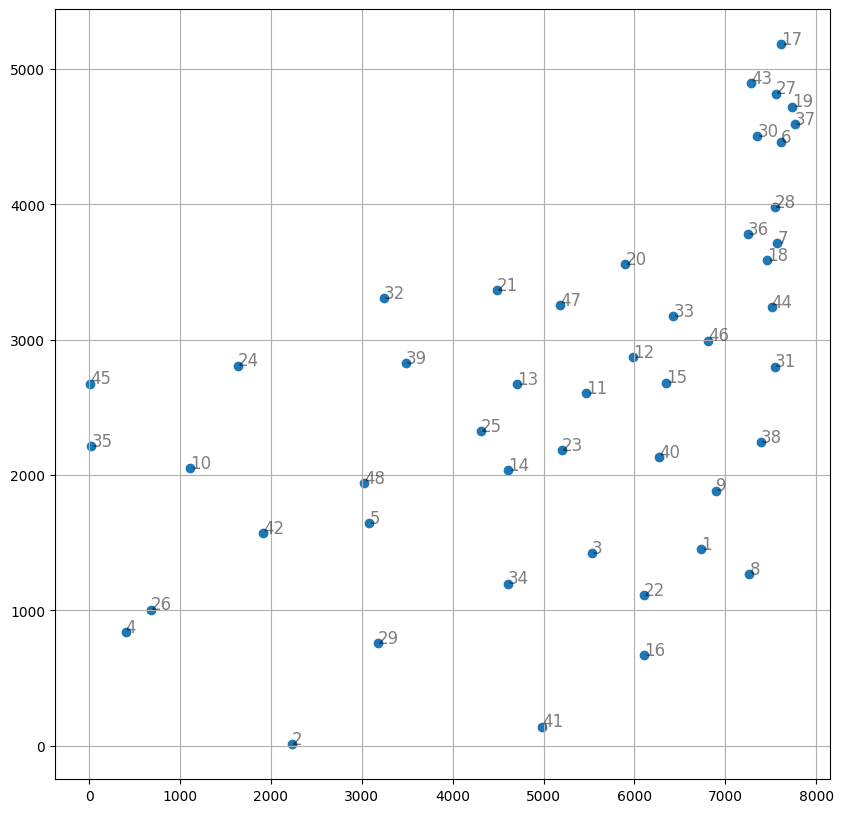

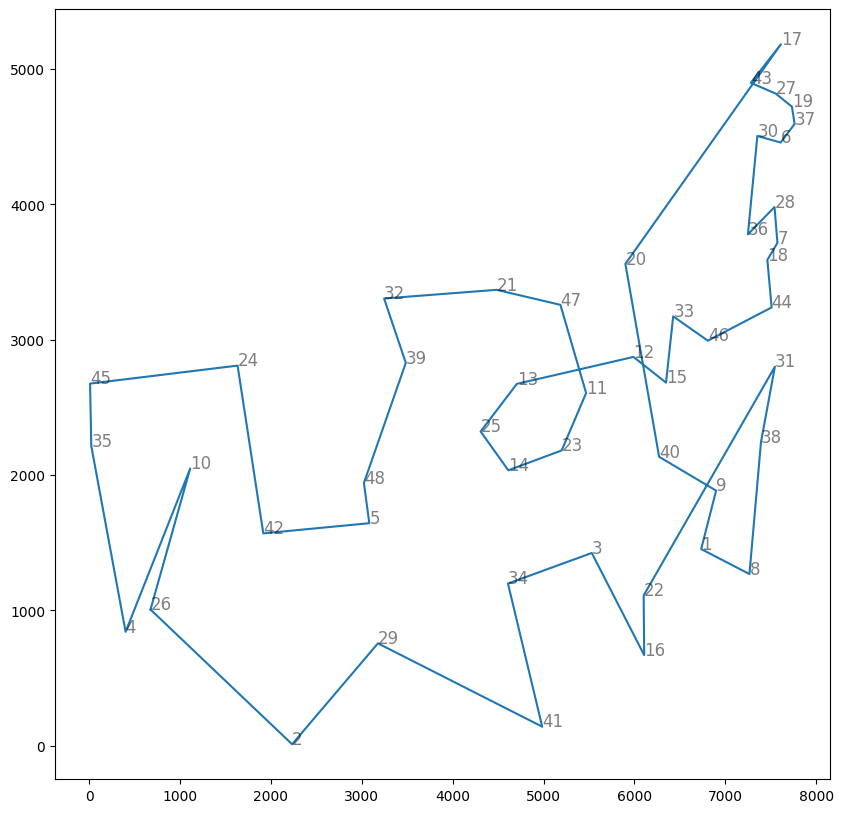

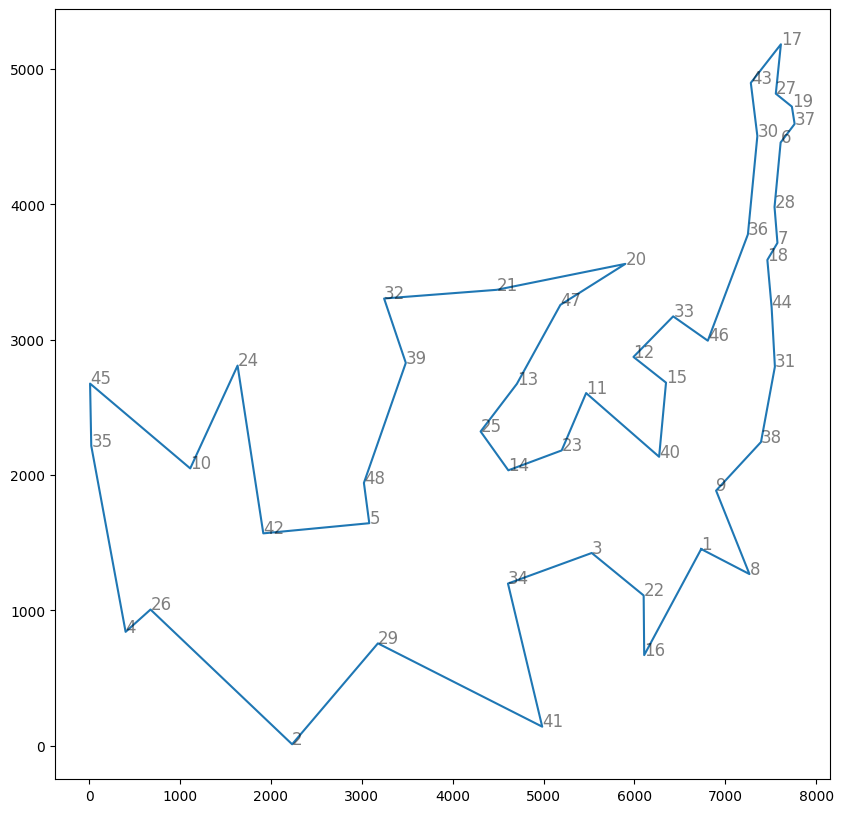

In [ ]:
new_results = new_tsp_solve(towns_filename = "att48",distance_mesure = att_distance,ideal_route=10628,move_method = "2-opt",initial_method= "greedy",grid = "on")